# Multi-resolution deconvolution of spatial transcriptomics

In this tutorial, we through the steps of applying DestVI for deconvolution of 10x Visium spatial transcriptomics profiles using an accompanying single-cell RNA sequencing data.

**Background:**

Spatial transcriptomics technologies are currently limited, because their resolution is limited to niches (spots) of sizes well beyond that of a single cell. Although several pipelines proposed joint analysis with single-cell RNA-sequencing (scRNA-seq) to alleviate this problem they are limited to a discrete view of cell type proportion inside every spot. This limitation becomes critical in the common case where, even within a cell type, there is a continuum of cell states. We present *Deconvolution of Spatial Transcriptomics profiles using Variational Inference (DestVI)*, a probabilistic method for multi-resolution analysis for spatial transcriptomics that explicitly models continuous variation within cell types.

**Plan for this tutorial:**

1. Loading the data
1. Training the single-cell model (scLVM) to learn a basis of gene expression on the scRNA-seq data
1. Training the spatial model (stLVM) to perform the deconvolution
1. Visualize the learned cell type proportions
1. Run our automated pipeline
1. Dig into the intra cell type information
1. Run cell-type specific differential expression

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()
#!pip install --quiet git+https://github.com/yoseflab/destvi_utils.git@main

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


In [3]:
import os
import tempfile

# import destvi_utils
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.model import CondSCVI, DestVI

In [4]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


Last run with scvi-tools version: 1.3.1.post1


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [5]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Data loading & processing

First, let's load the single-cell data. We profiled immune cells from murine lymph nodes with 10x Chromium, as a control / case study to study the immune response to exposure to a mycobacteria (refer to our paper for more info). We provide the preprocessed data from our reproducibility repository: it contains the raw counts (DestVI always takes raw counts as input).

Let's download our data from a comparative study of murine lymph nodes, comparing wild-type with a stimulation after injection of a mycobacteria. We have at disposal a 10x Visium dataset as well as a matching scRNA-seq dataset from the same tissue.

```{note}
Below we download the already preprocessed datasets. To see the exact preprocssing procedure on these datasets, please see the spatial section of the preprocessing tutorial:

[preprocessing tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/use_cases/preprocessing)

```

In [6]:
st_adata_path = os.path.join(save_dir.name, "st_lymph_node_preprocessed.h5ad")

st_adata = sc.read(
    st_adata_path,
    backup_url="https://figshare.com/ndownloader/files/52947032",
)
st_adata

  0%|          | 0.00/55.0M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 1092 × 1888
    obs: 'in_tissue', 'array_row', 'array_col', 'batch', 'LN', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'lymph_node'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'LN_colors', 'log1p'
    obsm: 'X_pca', 'X_umap', 'location', 'modules', 'spatial'
    layers: 'counts'

In [7]:
sc_adata_path = os.path.join(save_dir.name, "sc_lymph_node_preprocessed.h5ad")

sc_adata = sc.read(
    sc_adata_path,
    backup_url="https://figshare.com/ndownloader/files/52947086",
)
sc_adata

  0%|          | 0.00/111M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 14989 × 1888
    obs: 'n_genes', 'cell_types', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pred_cell_types', 'doublet_scores', 'doublet_predictions', 'MS', 'louvain_r0.5', 'louvain_r0.7', 'louvain_r1.0', 'leiden_r0.5', 'leiden_r0.7', 'leiden_r1.0', 'DC_A', 'DC_B', 'mono_1', 'mono_2', 'louvain_sub_0.1', 'louvain_sub_0.2', 'louvain_sub_0.3', 'louvain_sub', 'louvain_sub_1', 'louvain_sub_2', 'louvain_sub_3', 'SCANVI_pred_cell_types', 'SCVI_pred_cell_types', 'broad_cell_types'
    var: 'gene_ids-0', 'genome-0', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'n_counts', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'batch_colors', 'hvg', 'leiden', 'leiden_r1.0_colors', 'log1p', 'louvain', 'louvain_r0.5_colors', 'louvain_r0.7_colors', 'louvain_r1.0_colors', 'louvain_sub_0.2_colors', 'louvain_sub_0.3_colors', 'louvain_sub_1_colo

We clustered the single-cell data by major immune cell types. DestVI can resolve beyond discrete clusters, but need to work with an existing level of clustering. A rule of thumb to keep in mind while clsutering is that DestVI assumes only a single state from each cell type exists in each spot. For example, resting and inflammed monocytes cannot co-exist in one unique spot according to our assumption. Users may cluster their data so that this modeling assumption is as accurate as possible.

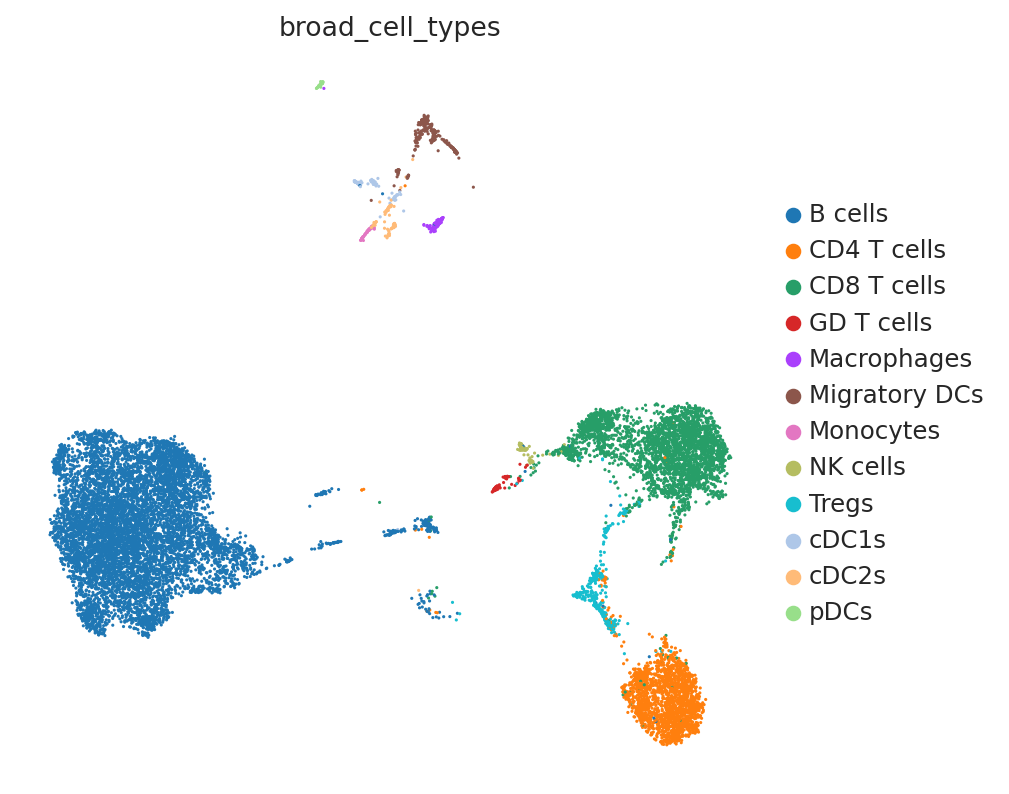

In [8]:
sc.pl.umap(sc_adata, color="broad_cell_types")

In [9]:
G = len(sc_adata.var_names)

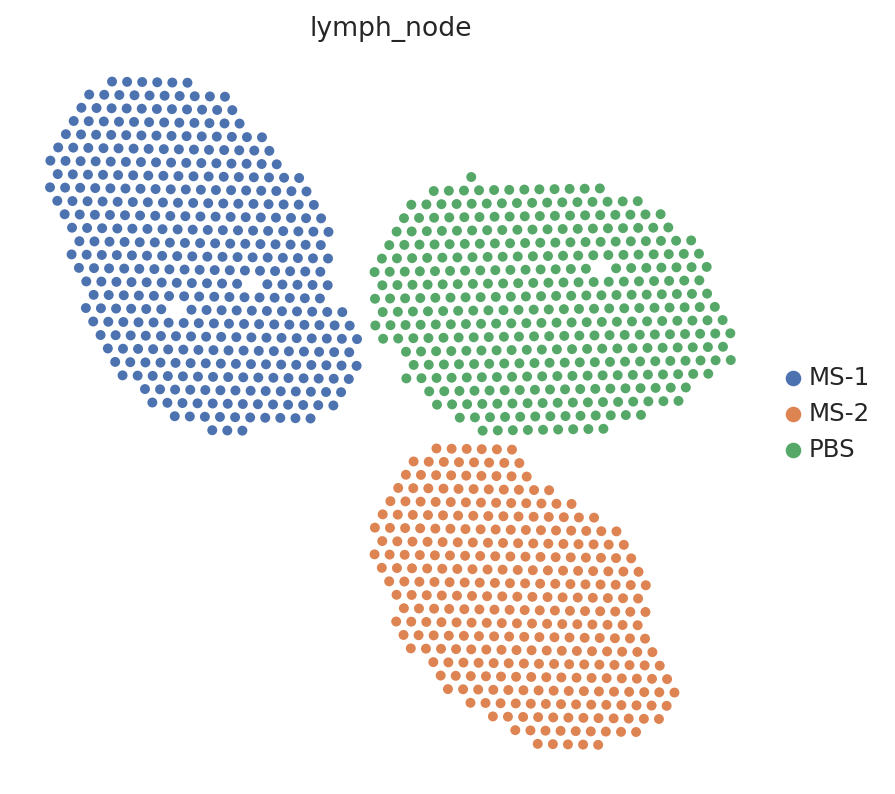

In [10]:
sc.pl.embedding(st_adata, basis="spatial", color="lymph_node", s=80)

## Fit the scLVM

In order to learn cell state specific gene expression patterns, we will fit the single-cell Latent Variable Model (scLVM) to single-cell RNA sequencing data from the same tissue.

In [11]:
CondSCVI.setup_anndata(sc_adata, layer="counts", labels_key="broad_cell_types")

As a first step, we embed our data using a cell type conditional VAE. We pass the layer containing the raw counts and the labels key. We train this model without reweighting the loss by the cell type abundance. Training will take around 5 minutes in a Colab GPU session.

In [12]:
sc_model = CondSCVI(sc_adata, weight_obs=False)
sc_model.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.1.post1.

Setup via `CondSCVI.setup_anndata` with arguments:

{'labels_key': 'broad_cell_types', 'layer': 'counts', 'batch_key': None}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_batch      │   1   │
│     n_cells      │ 14989 │
│     n_labels     │  12   │
│      n_vars      │ 1888  │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                         labels State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location        ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['broad_cell_types'] │    B cells    │          0          │
│                               │  CD4 T cells  │          1          │
│                               │  CD8 T cells  │          2          │
│                               │  GD T cells   │          3          │
│                               │  Macrophages  │          4          │
│                               │ Migratory DCs │          5          │
│                               │   Monocytes   │          6          │
│                               │   NK cells    │          7          │
│                               │     Tregs     │          8          │
│                               │     cDC1s     │          9          │
│                               │     cDC2s     │         10          │
│                               │     pDCs      │         11          │
└───────────────────────────────┴───────────────┴─────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

In [13]:
sc_model.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/300 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=300` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


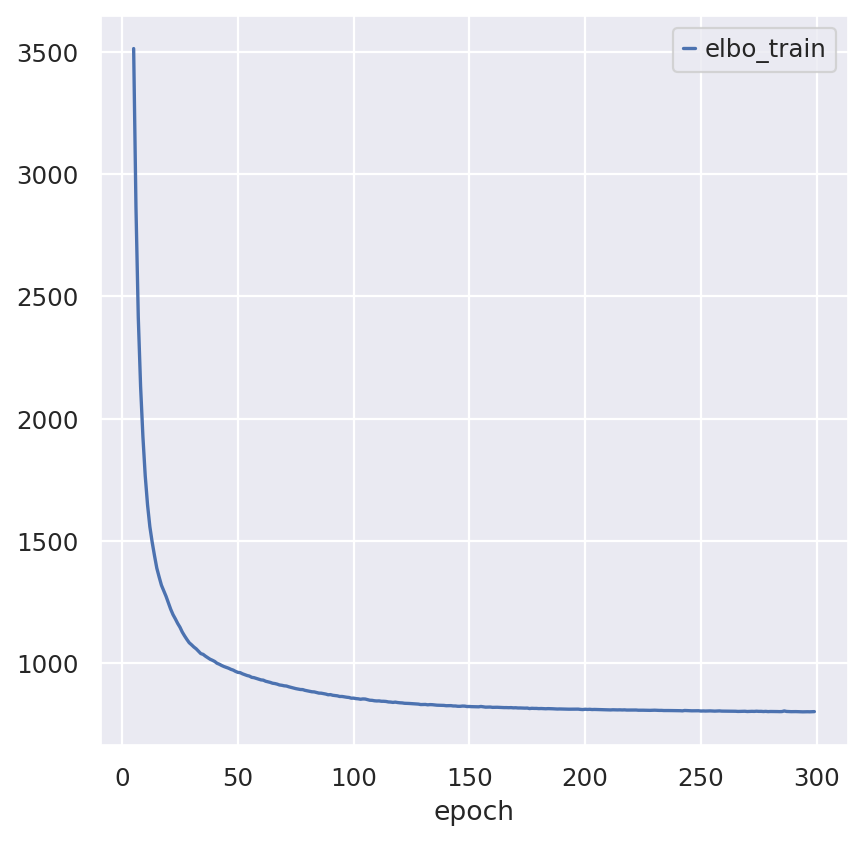

In [14]:
sc_model.history["elbo_train"].iloc[5:].plot()
plt.show()

Note that model converges quickly. Over experimentation with the model drastically reducing the number of epochs leads to decreased performance and performance deteriorates as max_epochs\<200.

## Deconvolution with stLVM

As a second step, we train our deconvolution model: spatial transcriptomics Latent Variable Model (stLVM).
We setup the DestVI model using the `counts` layer in `st_adata` that contains the raw counts. We then pass the trained `CondSCVI` model and generate a new model based on `st_adata` and `sc_model` using `DestVI.from_rna_model`.

The decoder network architecture will be generated from `sc_model`. Two neural networks are initiated for cell type proportions and gamma value amortization. Training will take around 5 minutes in a Colab GPU session.

Potential adaptations of `DestVI.from_rna_model` are:

1. increasing `vamp_prior_p` leads to less gradual changes in gamma values
1. more discretized values. Increasing `l1_sparsity` will lead to sparser results for cell type proportions.
1. Although we recommend using similar sequencing technology for both assays, consider changing `beta_weighting_prior` otherwise.

Technical Note: During inference, we adopt a variational mixture of posterior as a prior to enforce gamma values in stLVM match scLVM (see details in original publication). This empirical prior is based on cell type specific subclustering (using k-means to find `vamp_prior_p` clusters) of the posterior distribution in latent space for every cell.

In [15]:
DestVI.setup_anndata(st_adata, layer="counts")

In [16]:
st_model = DestVI.from_rna_model(st_adata, sc_model)
st_model.view_anndata_setup()

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7eb36023f7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/scipy.libs/libscipy_openblas-68440149.

Anndata setup with scvi-tools version 1.3.1.post1.

Setup via `DestVI.setup_anndata` with arguments:

{'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 1092  │
│      n_vars      │ 1888  │
└──────────────────┴───────┘

              Data Registry              
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃  scvi-tools Location   ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │ adata.layers['counts'] │
│    ind_x     │ adata.obs['_indices']  │
└──────────────┴────────────────────────┘

In [17]:
st_model.train(max_epochs=2500)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2500` reached.


Note that model converges quickly. Over experimentation with the model drastically reducing the number of epochs leads to decreased performance and we advocate against max_epochs\<1000.

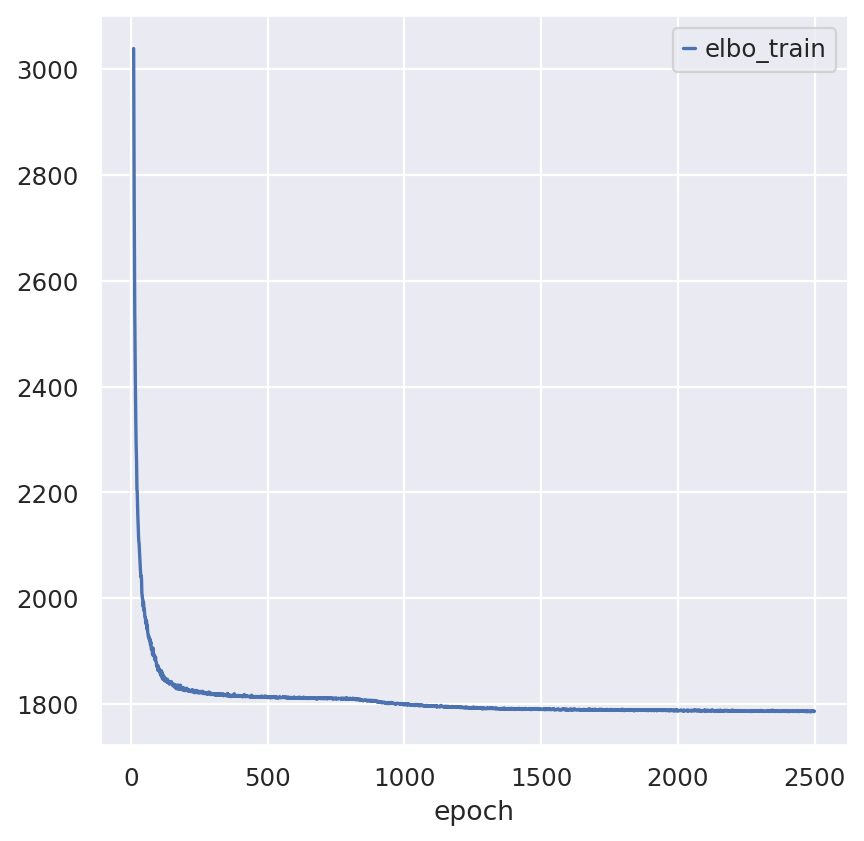

In [18]:
st_model.history["elbo_train"].iloc[10:].plot()
plt.show()

The output of DestVI has two resolution. At the broader resolution, DestVI returns the cell type proportion in every spot. At the more granular resolution, DestVI can impute cell type specific gene expression in every spot.

## Cell type proportions

We extract the computed cell type proportions and display them in spatial embedding. These values are directly calculated by normalized the spot-level parameters from the stLVM model.

In [19]:
st_adata.obsm["proportions"] = st_model.get_proportions()

In [20]:
st_adata.obsm["proportions"].head(5)

,B cells,CD4 T cells,CD8 T cells,GD T cells,Macrophages,Migratory DCs,Monocytes,NK cells,Tregs,cDC1s,cDC2s,pDCs
AAACCGGGTAGGTACC-1-0,0.625474,0.034695,0.044288,0.016855,0.066764,0.039809,0.026428,0.002363,0.042902,0.047324,0.032930,0.020168
AAACCTCATGAAGTTG-1-0,0.549694,0.060474,0.040493,0.022915,0.071935,0.065604,0.017119,0.003015,0.037082,0.054938,0.062137,0.014594
AAAGACTGGGCGCTTT-1-0,0.502748,0.058723,0.058353,0.029249,0.062899,0.090567,0.009716,0.001905,0.072961,0.053651,0.054533,0.004694
AAAGGGCAGCTTGAAT-1-0,0.105152,0.216241,0.171961,0.077413,0.060472,0.109127,0.041788,0.004063,0.119872,0.058688,0.029216,0.006007
AAAGTCGACCCTCAGT-1-0,0.759588,0.025904,0.006341,0.013572,0.034330,0.031182,0.014615,0.001372,0.020829,0.041626,0.041536,0.009106


In [21]:
ct_list = ["B cells", "CD8 T cells", "Monocytes"]
for ct in ct_list:
    data = st_adata.obsm["proportions"][ct].values
    st_adata.obs[ct] = np.clip(data, 0, np.quantile(data, 0.99))

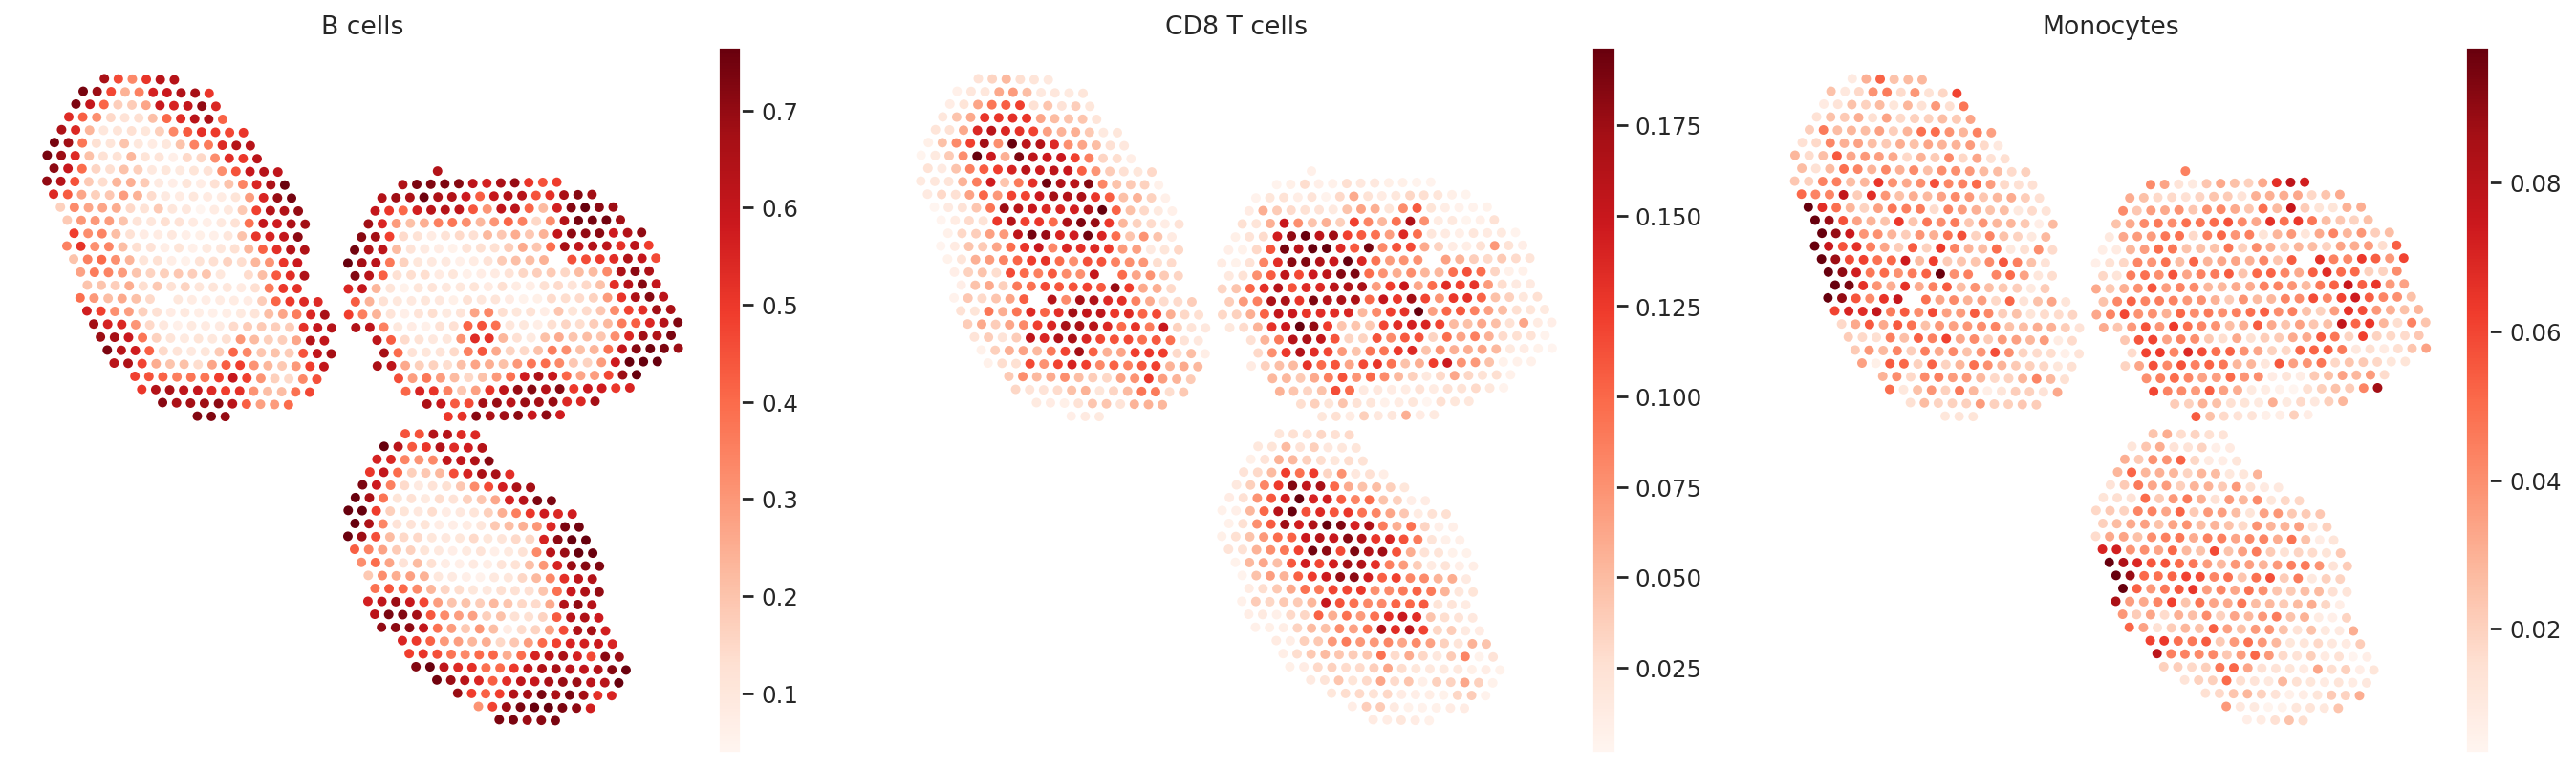

In [22]:
sc.pl.embedding(st_adata, basis="spatial", color=ct_list, cmap="Reds", s=80)

Because the inference of cell type specific gene expression is prone to error when the cell type is not present in a spot, and because the cell type proportion values estimated by stLVM are not sparse, we provide an automated way of thresholding them. For follow-up analysis we recommend checking these threshold values and adjust them for each cell type.

This part of the software is not directly available in scvi-tools, but instead in the util package `destvi_utils` (installable from GitHub; refer to the top of this tutorial).

In [24]:
"""ct_thresholds = destvi_utils.automatic_proportion_threshold(
    st_adata, ct_list=ct_list, kind_threshold="secondary"
)"""

'ct_thresholds = destvi_utils.automatic_proportion_threshold(\n    st_adata, ct_list=ct_list, kind_threshold="secondary"\n)'

In terms of cell type location, we observe a strong compartimentalization of the cell types in the lymph node (B cells / T cells), as expected. We also observe a differential localization of the monocytes (refer to the paper for further details).

## Intra cell type information

At the heart of DestVI is a multitude of latent variables (5 per cell type per spots). We refer to them as "gamma", and we may manually examine them for downstream analysis

In [25]:
# more globally, the values of the gamma are all summarized in this dictionary of data frames
for ct, g in st_model.get_gamma().items():
    st_adata.obsm[f"{ct}_gamma"] = g

In [26]:
st_adata.obsm["B cells_gamma"].head(5)

,0,1,2,3,4
AAACCGGGTAGGTACC-1-0,0.011587,0.032210,0.069874,-0.137888,-1.108997
AAACCTCATGAAGTTG-1-0,-0.287029,-0.863993,0.076867,-0.001936,-0.733016
AAAGACTGGGCGCTTT-1-0,-1.774701,-1.090885,0.396542,-0.029839,-1.219770
AAAGGGCAGCTTGAAT-1-0,-0.576535,-0.329290,-0.197335,0.303819,-0.310637
AAAGTCGACCCTCAGT-1-0,0.390809,-0.125783,0.537635,-0.925797,-0.444873


Because those values may be hard to examine manually for end-users, we presented in the manuscript several methods for prioritizing the study of different cell types (based on spatially-weighted PCA and Hotspot). Below we provide the result of our automated pipeline with the spatially-weighted PCA.

More precisely, for de novo detection of spatial patterns, we study the gamma space and use a spatially-informed PCA to find the spatial axis of variation in this gamma space. We use EnrichR to functionally annotate these genes. In particular, we recover enrichment of IFN genes across monocytes as well as B cells

The function `explore_gamma_space` operates as follow, for each cell type individually:

1. Select all the spots with proportions beyond the magnitude threshold,
1. Calculate the spot-specific cell-type-specific embeddings gamma,
1. Calculate the first two principal vectors of those gamma values, weighted by the spatial coordinates,
1. Project all the embeddings (considered spots, and single-cell profiles) onto this 2D space,
1. Map each spot (or cell) to a specific color via its 2d coordinate, using the `cmap2d` package
1. Plot (A) the color of every spot in spatial coordinates (B) the color of every spot in sPC space (C) the color of every single cell in sPC space
1. Calculate genes enriched in each direction and group into pathways with `EnrichR`

In [ ]:
# destvi_utils.explore_gamma_space(
# st_model, sc_model, ct_list=ct_list, ct_thresholds=ct_thresholds)

We anticipate this to be a valuable ressource for formulating scientific hypotheses from ST data.

## Example with B cells; and differential expression

First, we display the genes identified via the pipeline as well as Hotspot (see manuscript), using the B-cell-specific gene expression values imputed by DestVI.

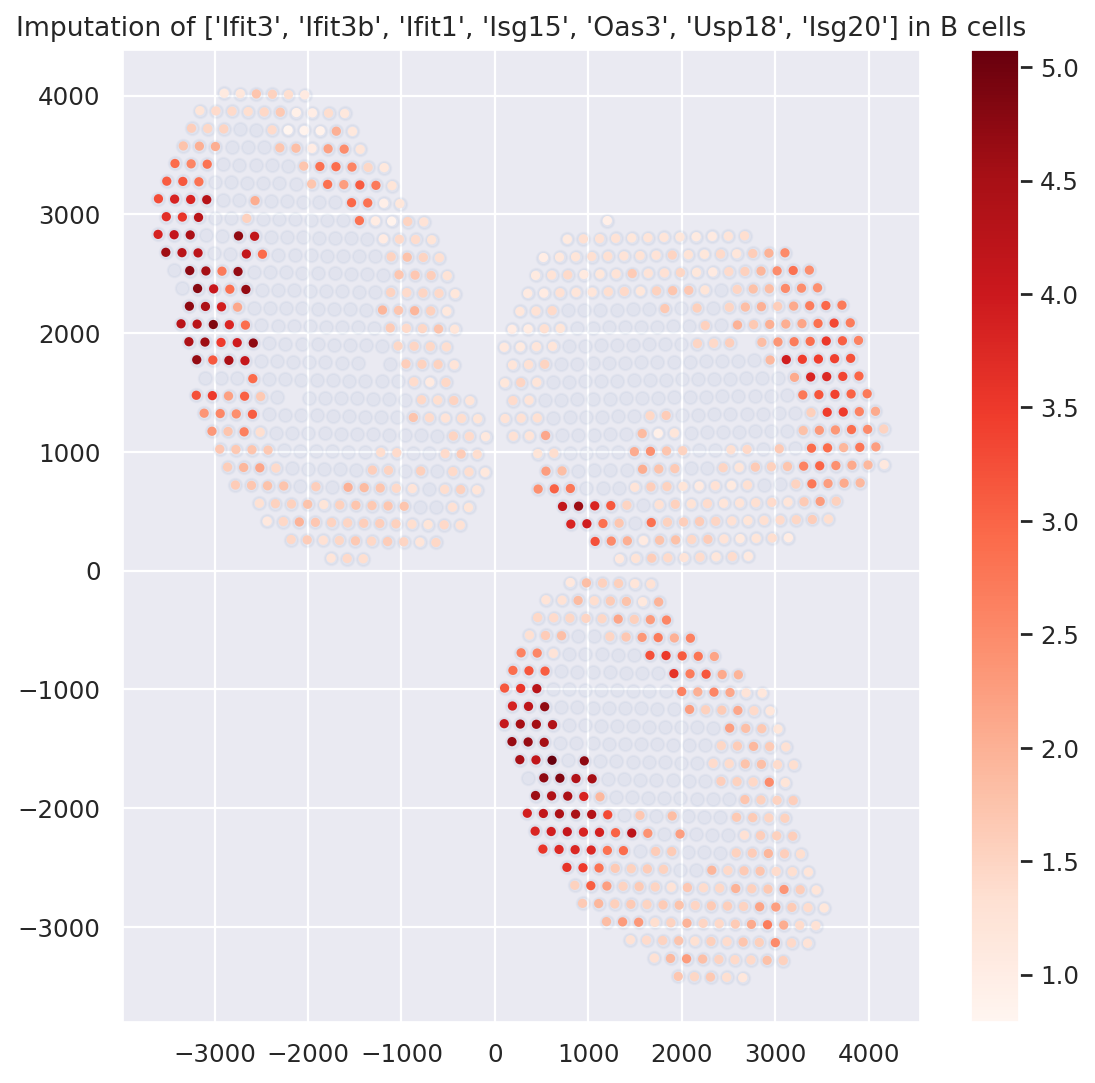

In [29]:
plt.figure(figsize=(8, 8))

ct_name = "B cells"
gene_name = ["Ifit3", "Ifit3b", "Ifit1", "Isg15", "Oas3", "Usp18", "Isg20"]

# we must filter spots with low abundance (consult the paper for an automatic procedure)
indices = np.where(st_adata.obsm["proportions"][ct_name].values > 0.2)[0]

# impute genes and combine them
specific_expression = np.sum(st_model.get_scale_for_ct(ct_name, indices=indices)[gene_name], 1)
specific_expression = np.log(1 + 1e4 * specific_expression)

# plot (i) background (ii) g
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(
    st_adata.obsm["location"][indices][:, 0],
    st_adata.obsm["location"][indices][:, 1],
    c=specific_expression,
    s=10,
    cmap="Reds",
)
plt.colorbar()
plt.title(f"Imputation of {gene_name} in {ct_name}")
plt.show()

Second, we apply a Kolmogorov-Smirnov test on the generated counts to study the differential expression of B cells in the exposed lymph nodes, between the interfollicular area (IFA) and the rest. We display the identified IFN genes in a Volcano plot and see significant upregulation in the IFA area of exposed lymph nodes.

In [31]:
"""ct = "B cells"
imputation = st_model.get_scale_for_ct(ct)
color = np.log(1 + 1e5 * imputation["Ifit3"].values)
threshold = 4

mask = np.logical_and(
    np.logical_or(st_adata.obs["LN"] == "TC", st_adata.obs["LN"] == "BD"),
    color > threshold,
).values

mask2 = np.logical_and(
    np.logical_or(st_adata.obs["LN"] == "TC", st_adata.obs["LN"] == "BD"),
    color < threshold,
).values

_ = destvi_utils.de_genes(
    st_model, mask=mask, mask2=mask2, threshold=ct_thresholds[ct], ct=ct, key="IFN_rich"
)

display(st_adata.uns["IFN_rich"]["de_results"].head(10))

destvi_utils.plot_de_genes(
    st_adata,
    interesting_genes=["Ifit3", "Ifit3b", "Ifit1", "Isg15", "Oas3", "Usp18", "Isg20"],
    key="IFN_rich",
)"""

'ct = "B cells"\nimputation = st_model.get_scale_for_ct(ct)\ncolor = np.log(1 + 1e5 * imputation["Ifit3"].values)\nthreshold = 4\n\nmask = np.logical_and(\n    np.logical_or(st_adata.obs["LN"] == "TC", st_adata.obs["LN"] == "BD"),\n    color > threshold,\n).values\n\nmask2 = np.logical_and(\n    np.logical_or(st_adata.obs["LN"] == "TC", st_adata.obs["LN"] == "BD"),\n    color < threshold,\n).values\n\n_ = destvi_utils.de_genes(\n    st_model, mask=mask, mask2=mask2, threshold=ct_thresholds[ct], ct=ct, key="IFN_rich"\n)\n\ndisplay(st_adata.uns["IFN_rich"]["de_results"].head(10))\n\ndestvi_utils.plot_de_genes(\n    st_adata,\n    interesting_genes=["Ifit3", "Ifit3b", "Ifit1", "Isg15", "Oas3", "Usp18", "Isg20"],\n    key="IFN_rich",\n)'